In [13]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
import math
plt.rcdefaults()
%matplotlib inline

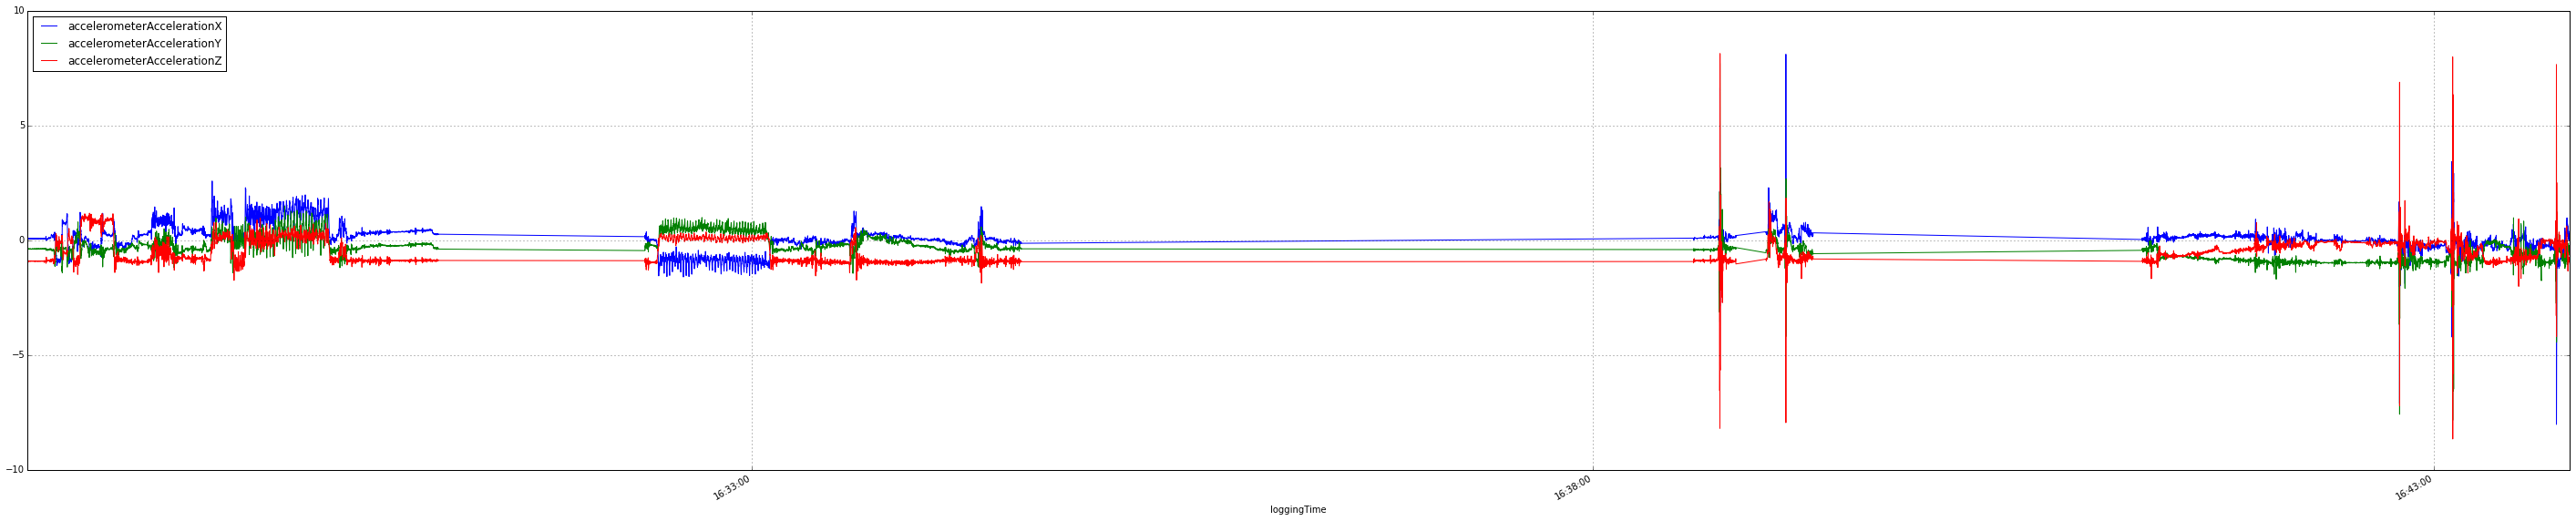

In [109]:
basePath = "/Users/karthik/Documents/workspace/sequoia-ml/data/"
f = "2015-08-29_16-41-16.csv"
from os import listdir
from os.path import isfile, join
onlyfiles = [ f for f in listdir(basePath) if isfile(join(basePath,f)) ]
df_list = []
df = []
for f in onlyfiles:
    df1 = pd.read_csv(basePath + f, index_col = "loggingTime",parse_dates=True, infer_datetime_format=True)
    if len(df)==0:
        df = df1
    else:
        df = df.append(df1)            
    #df_list.append(df1)
#df = pd.concat(df_list)
a_df = df[["accelerometerAccelerationX","accelerometerAccelerationY","accelerometerAccelerationZ"]]
a_df.plot(figsize=(50,10))

In [107]:
onlyfiles

['2015-08-29_16-28-41.csv',
 '2015-08-29_16-32-21.csv',
 '2015-08-29_16-38-36.csv',
 '2015-08-29_16-39-01.csv',
 '2015-08-29_16-41-16.csv']

,loggingSample,locationTimestamp_since1970,locationLatitude,locationLongitude,locationAltitude,locationSpeed,locationCourse,locationVerticalAccuracy,locationHorizontalAccuracy,locationFloor,...,pedometerNumberofSteps,pedometerDistance,pedometerFloorAscended,pedometerFloorDescended,altimeterTimestamp_sinceReboot,altimeterReset,altimeterRelativeAltitude,altimeterPressure,deviceOrientation,state
count,47904.000000,4.790400e+04,47904.000000,47904.000000,47904.000000,47904.000000,47904.000000,47904.000000,47904.000000,47904,...,47904.000000,47904.000000,47904,47904,47904.000000,47904,47904.000000,47904.000000,47904.000000,47904.000000
mean,7002.279977,1.440846e+09,12.969659,77.596253,905.584241,-0.441857,24.897587,26.741544,136.650452,-9999,...,135.871451,127.408354,0,0,139804.792378,0,0.733335,90.571118,3.461298,1.448689
std,4502.733660,3.170440e+02,0.004425,0.001401,22.242952,0.684116,71.856421,20.092555,115.714221,0,...,93.067581,90.060053,0,0,320.129434,0,0.508646,0.005580,1.774693,1.260241
min,1.000000,1.440846e+09,12.966970,77.595076,867.792200,-1.000000,-1.000000,8.000000,10.000000,-9999,...,0.000000,0.000000,0,0,139384.257124,0,-0.117798,90.560520,1.000000,0.000000
25%,2897.000000,1.440846e+09,12.967069,77.595236,887.336200,-1.000000,-1.000000,12.000000,30.000000,-9999,...,56.000000,50.728620,0,0,139501.136099,0,0.336975,90.566340,1.000000,0.000000
50%,6889.000000,1.440846e+09,12.967184,77.595508,915.472300,-1.000000,-1.000000,18.494797,100.000000,-9999,...,139.000000,121.925800,0,0,139690.298297,0,0.631470,90.572240,4.000000,2.000000
75%,10881.000000,1.440847e+09,12.967331,77.595985,920.015500,0.000000,-1.000000,46.625683,225.469440,-9999,...,239.000000,230.110900,0,0,140175.095787,0,1.169373,90.575470,5.000000,2.000000
max,15703.000000,1.440847e+09,12.978615,77.599042,933.216700,1.670000,344.531250,191.624174,454.972040,-9999,...,257.000000,250.145600,0,0,140290.694944,0,1.699036,90.580450,6.000000,4.000000


#Features

In [112]:
ndf = df[["state"]]
ndf["acc"] = (df[["accelerometerAccelerationX", "accelerometerAccelerationY", "accelerometerAccelerationZ"]]**2).sum(axis=1)
ndf["gyro"] = (df[["gyroRotationX", "gyroRotationY", "gyroRotationZ"]]**2).sum(axis=1)
gdf = ndf.groupby(pd.TimeGrouper('1s',closed='left'))
groups = [group for group in gdf]
windows = []
overlap = 3
for i in range(overlap-1,len(groups)):
    name = groups[i][0]
    windows.append([name, pd.concat([x[1] for x in groups[i-overlap+1:i+1]])])

In [116]:
def extract_features(df_list):
    features_names = ["avg_acc", "max_acc", "min_acc", "avg_gyro", "max_gyro", "min_gyro", "max_state"]
    f_map = {}
    for fname in features_names:
        f_map[fname] = []
        
    for df in df_list:
        agg = df.mean()
        if np.isnan(agg["acc"]):
            continue
        f_map["avg_acc"].append(agg["acc"])
        f_map["avg_gyro"].append(agg["gyro"])

        agg = df.max()
        f_map["max_acc"].append(agg["acc"])   
        f_map["max_gyro"].append(agg["gyro"])
        f_map["max_state"].append(agg["state"]+0.1)

        agg = df.min()
        f_map["min_acc"].append(agg["acc"])    
        f_map["min_gyro"].append(agg["gyro"])
    return f_map

In [118]:
f_map = extract_features([window[1] for window in windows])    

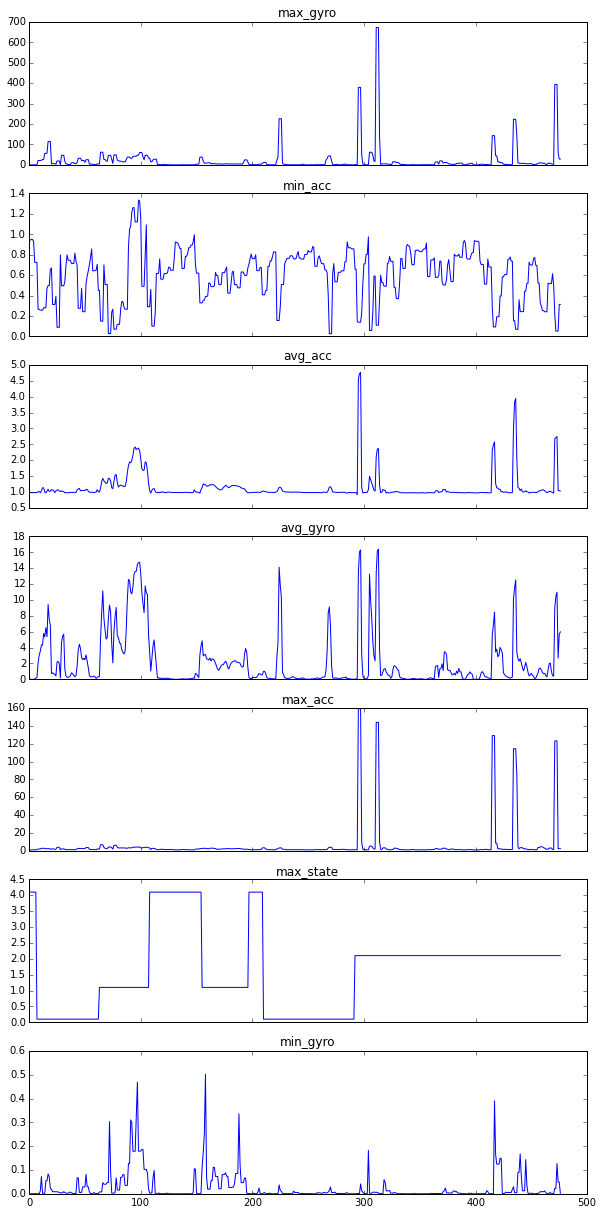

In [119]:
f, ax = plt.subplots(len(f_map), sharex=True,figsize=(10,len(f_map)*3))
for i,f in enumerate(f_map):
    ax[i].plot(f_map[f])
    ax[i].set_title(f)

In [40]:
a["state"]

0.0